In [50]:
#Import Tensor Flow and other helper Libraries
import tensorflow as tf

#Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

From https://www.cs.toronto.edu/~kriz/cifar.html, the CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch,e ach with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The trainingbatched contain the remaining images in random order, bt some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

The classes are completly mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks

Images are 32 x 32 pixels

This time we will create a CNN model
   - conv2D layers
   - maxPooling2D layers
   - build, train, asses, predict
   - visualize learned filters

In [51]:
#2. Load the CIFAR-10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [52]:
#3. Pre-process and Explore the data

#Preprocess the data: convert pixel intensities to double values between 0 and 1
#Dividing by 255 becauase it's max value for image intensities
x_train, x_test = x_train / 255.0, x_test / 255.0
#Check the data has the correct shape/dimension
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


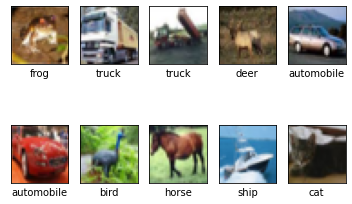

In [53]:
# Plot the first 10 images from the training set and display the class name
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

A sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

A sequential model in not appropriate when:
- Your odel has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- you need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch model)

In [54]:
# 4. Build the tf.keras.Sequential model by stacking layers
# Check out a different way to do this
# We will create an "empty" sequential model and then add layers, one by one
# We will alternate between a Conv2D layer and a maxpooling layer
# We will need one Flatten and one (or more) Dense Layers at the end

# Convolutional layers will have (see tensorflow api docs)
# - number of output filter in the convolution (32)
# - size of the filter/kernel as a tuple of 2 values (or just 1 value) : (3,3) or 3 means 3 by 3
# - strides as a tuple or 1 value: default value is 1
# - padding: "valid" means no padding. "same" results in padding evenly to the left/right or 
# - up/down of the input such that output has the same height/width dimension as the input
# - nonlinear activation function" relu, sigmoid, tanh
# - size of input shape: our images are 32 by 32 by 3 (because they are RGB)
# - size of input shape: our images are 32 by 32 by 3 (because they are RGB)

# Max Pooling layer will have as arguments:
# - pool size as a tuple or just 1 value: teh size of the window over which we do max
# - strides (optional), same as for Conv2D
# - padding (optional), same as for Conv2D

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(10)) # last layer should be the size of the output

#try this again with other activation functions: sigmoid, tanh

In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 7200)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Because no padding was specified int he conv layer, the output shaped formt eh convlutional
# layer is 30 x 30
# max pooling layer reduces every dimension by 2, hence 15 x 15 is the size of the output

# Number of Parameters:
# - for the conv layer: size of each filter (3 * 3* 3), time num. filters (32), + biases (32)
# - for max pooling layer: no parameters
# - for the flaten layer: no parameters
# - for the last dense layer: 7200 * 10 + 10 (one weight for each conv result value, per class)

In [57]:
#For each example the model returns a vector of "logits" or "log-odds" scores, one for each class
# pass 1 training data image to the model and convert the predictions into a numpy array
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.01558122, -0.01203311,  0.06898293, -0.4990317 ,  0.1587086 ,
         0.09174135,  0.03375299, -0.08096939, -0.00457526,  0.11399823]],
      dtype=float32)

In [58]:
#Use the tf.nn.softmax function to convert these logits into "probabilities" for each class:
tf.nn.softmax(predictions).numpy() # probabilities
# We haven't trained out network yet. thus, the image has almost an equal
# probability of being in each category

array([[0.09853349, 0.09888373, 0.10722835, 0.06076087, 0.11729432,
        0.10969668, 0.10351647, 0.09229669, 0.09962393, 0.11216556]],
      dtype=float32)

In [59]:
#5. Choose an optimizer and loss function for training

# Deep learning neural networks are trained using the stochastic gradient descent
# algorithm. As part of the optimizatio algorithm, the error for the curren
# model must be estimated repeatedly. This requires the coice of an error function
# conventionally called a loss function, that can be used to estimate the
# of the function that the weights can be updated to reduce the loss on the next evaluation

# The losses.SparseCategoricalCrossentropy loss takes a vector of logits and a True index ans
# returns a scalar loss for each example

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# This loss is equal to the negative log probability of the true class: It is zero if the model
# is sure of the correct class. The untrained model gives probabilities to random
# (1/10) for each class), so the initial loss should be closs to -tf.math.log(1/10) ~= 2.3

loss_fn(y_train[:1], predictions).numpy() #untrained neural network

2.2680247

In [61]:
# Ready to Compile
# optimizer parameter = 'adam'. Other optimizer options here:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# loss = the name of the loss function
# Typically, you will use metrics=['accuracy']
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# The model.fit method adjusts the model parameters to minimize the loss
# We will train for 20 iterations (Usually, will want to start with a small #)

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Can see the 20th epoch is not the lowest accuracy. Maybe, next training
# We should go lower

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4737 - accuracy: 0.4827 - val_loss: 1.2979 - val_accuracy: 0.5498
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2120 - accuracy: 0.5801 - val_loss: 1.1898 - val_accuracy: 0.5833
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1174 - accuracy: 0.6147 - val_loss: 1.1648 - val_accuracy: 0.5990
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0513 - accuracy: 0.6389 - val_loss: 1.1181 - val_accuracy: 0.6082
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9925 - accuracy: 0.6596 - val_loss: 1.1209 - val_accuracy: 0.6152
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9424 - accuracy: 0.6781 - val_loss: 1.0537 - val_accuracy: 0.6390
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9067 - accuracy: 0.6916 - val_loss: 1.1128 - val_accuracy:

In [62]:
# 7a. Evaluate the model: compare how the model performs on the test dataset

# The Model.evaluate method checks the models performance, usuall on a "Va"
# or "Test-set"

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 1.0432 - accuracy: 0.6441 - 564ms/epoch - 2ms/step

Test accuracy: 0.64410001039505


313/313 - 1s - loss: 1.0432 - accuracy: 0.6441 - 559ms/epoch - 2ms/step


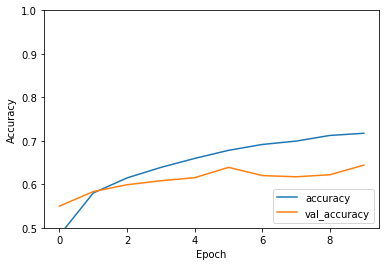

In [63]:
#7b. Plot training vs testing accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [70]:
#8. Make Predicitions

# If you want your model to return a probability, you can wrap the trained model
# the softmax classifier to it:

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test[:10]) #test the first 5 images
#print(predictions.shape)
predictions[0]

array([1.98214175e-03, 1.20727986e-04, 7.93843996e-03, 7.45967269e-01,
       1.84687739e-03, 1.55697867e-01, 2.25629285e-02, 2.26234406e-04,
       6.33643195e-02, 2.93197256e-04], dtype=float32)

In [71]:
# Apply a label and compare with the test label

print(np.argmax(predictions, axis=1))
print(y_test[:10]) 

[3 1 8 0 4 6 1 6 3 1]
[[3]
 [8]
 [8]
 [0]
 [6]
 [6]
 [1]
 [6]
 [3]
 [1]]


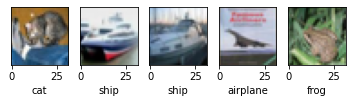

In [72]:
# View the first five images, to check the validity of the labels
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks()
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.xlabel(class_names[y_test[i][0]])
plt.show()

In [74]:
# 9. Take a look at the learned parameters (Important to look at)

filters, biases = model.layers[0].get_weights() #The layer with th 30,000 weights
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

(3, 3, 3, 32)


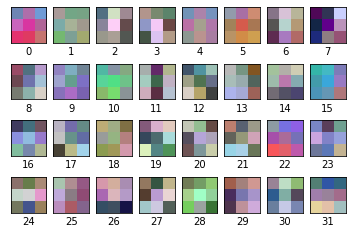

In [78]:
#reshape to rgb shape
# filters_rgb = filters.reshape(32,32,3,10)
# plot the 10 filters
n_filters = 32
for i in range(n_filters):
    # get the filter
    f = filters[:,:,:,i]
    plt.subplot(4, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(i)
    plt.imshow(f)
plt.show()

### What Have We Learned?
1. Import Tensorflow and new helper libraries
2. Load the data set
3. Pre-process data. Verify data shape and display
4. build the network model
    - Sequential
    - Stack layers, one at a time
    - Every conv2D layer is followed by a MaxPooling2D layer
5. Choose Optimizer and loss function
6. Compile and train. Onserve loss and accuracy over time
    - Accuracy improves with CNN
    - Accuracy improves with multiple conv2 + Max Pooling2D layers
7. Run on Testing Data. Observe Accuracy
8. Predict on new images
9. Visualize learned filters
    - In first convolutional lyers
    - In later convolutional layers